# Домашнее задание

## Коваленков Дмитрий

В этом задании мы попрактикуемся в методах снижения размерности и кластеризации данных. 

Мы будем работать с набором данных Samsung Human Activity Recognition. Скачайте данные по ссылке https://yadi.sk/d/_WFxgSIuBF06Rg. Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3, также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [29]:
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook


%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, Birch
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 17

In [3]:
#"C:\Users\Дмитрий\Documents\GitHub\samsung_HAR\samsung_test.txt"
X_train = np.loadtxt("samsung_HAR//samsung_train.txt")
y_train = np.loadtxt("samsung_HAR//samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_HAR//samsung_test.txt")
y_test = np.loadtxt("samsung_HAR//samsung_test_labels.txt").astype(int)

Для кластеризации нам не нужен вектор ответов. Объедините обучающую и тестовую выборки.

In [4]:
X_test.shape, X_train.shape

((2947, 561), (7352, 561))

In [5]:
#your code here
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

Эти метки соответствуют:

1 - ходьбе,
2 - подъему вверх по лестнице,
3 - спуску по лестнице,
4 - сидению,
5 - стоянию,
6 - лежанию

Отмасштабируйте выборку с помощью StandardScaler.

In [7]:
#your code here
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state.

Text(0, 0.5, 'explained_variance_ratio')

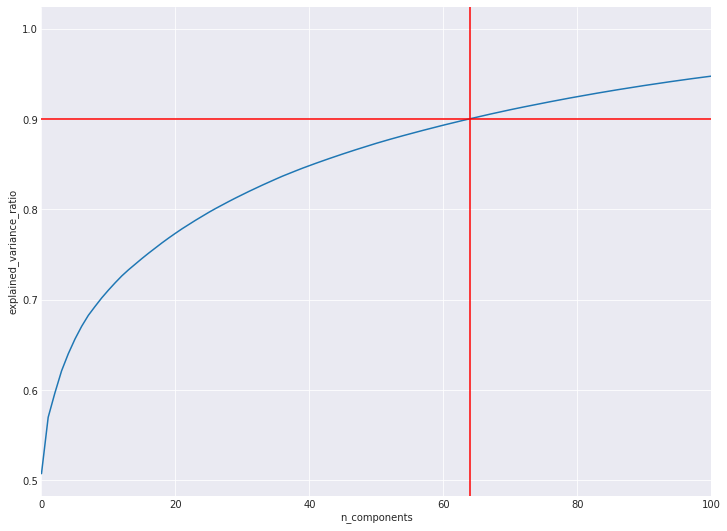

In [8]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.9, c = 'r')
plt.axvline(64, c = 'r')
plt.xlim(0,100)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')

<span style="color:blue"> Как видно из графика, достаточно снизить размерность до ~64</span>

In [9]:
#your code here
pca = PCA(n_components=64)
X_pca = pca.fit_transform(X_scaled)

Визуализируйте данные в проекции на первые две главные компоненты.

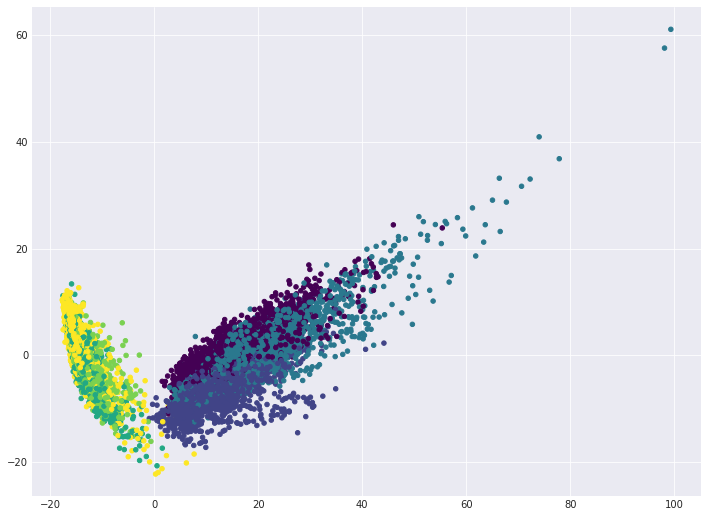

In [10]:
#your code here
plt.scatter(X_pca[:,0],X_pca[:,1] , c=y, s=20, cmap='viridis');

Сделайте кластеризацию данных методом KMeans, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае нужно искать 6 кластеров (так как у нас 6 классов).

Параметры:

n_clusters = n_classes (число уникальных меток целевого класса)

n_init = 100

random_state = RANDOM_STATE (для воспроизводимости результата)

In [11]:
kmeans = KMeans(n_clusters=6,n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
labels = kmeans.predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

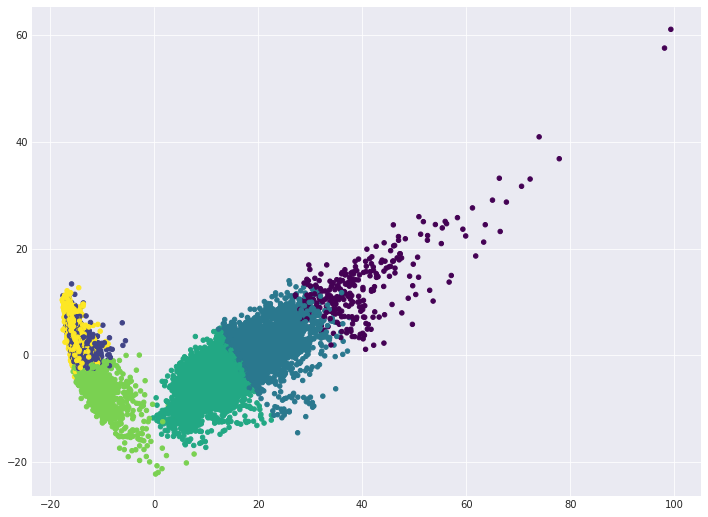

In [12]:
plt.scatter(X_pca[:,0],X_pca[:,1] , c=labels, s=20, cmap='viridis');

Выведите на экран значения метрик качества кластеризации

In [13]:
results = pd.DataFrame()

In [14]:
def writer(dataframe, model_name, model):
    '''
    Записывает все метрики кластеризации в таблицу для модели model 
    '''
    results.loc['Homogeneity', model_name] = round(metrics.homogeneity_score(y, model.labels_),2)
    results.loc['Completeness', model_name] = round(metrics.completeness_score(y, model.labels_),2)
    results.loc['V-measure', model_name] = round(metrics.v_measure_score(y, model.labels_),2)
    results.loc['Adjusted Rand-Index', model_name] = round(metrics.adjusted_rand_score(y, model.labels_),2)
    results.loc['Adjusted mutual info score', model_name] = round(metrics.adjusted_mutual_info_score(y, model.labels_),2)
    results.loc['Silhouette Coefficient', model_name] = round(metrics.silhouette_score(X, model.labels_, sample_size=len(X)),2)
    

In [15]:
writer(results, 'KMeans', kmeans)

In [16]:
results

,KMeans
Homogeneity,0.54
Completeness,0.58
V-measure,0.56
Adjusted Rand-Index,0.42
Adjusted mutual info score,0.54
Silhouette Coefficient,0.14


Теперь попробуем сделать кластеризацию с помощью AgglomerativeClustering (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [17]:
ag = AgglomerativeClustering(n_clusters=6, 
                             linkage='ward').fit(X_pca)

Выведите метрики качества для полученного разбиения на кластеры. Сравните с kmeans. Запишите выводы!

In [18]:
writer(results, 'AgglomerativeClustering', ag)
results


,KMeans,AgglomerativeClustering
Homogeneity,0.54,0.56
Completeness,0.58,0.62
V-measure,0.56,0.59
Adjusted Rand-Index,0.42,0.45
Adjusted mutual info score,0.54,0.56
Silhouette Coefficient,0.14,0.13


Попробуйте применить другие методы кластеризации из sklearn. Также вычислите метрики качества и сделайте вывод о том, какой метод сработал лучше.

In [22]:
birch = Birch(n_clusters=6)
birch.fit(X_pca)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=6,
   threshold=0.5)

In [27]:
writer(results, 'Birch', birch)

In [28]:
results

,KMeans,AgglomerativeClustering,DBSCAN,Birch
Homogeneity,0.54,0.56,-0.0,0.56
Completeness,0.58,0.62,1.0,0.62
V-measure,0.56,0.59,-0.0,0.59
Adjusted Rand-Index,0.42,0.45,0.0,0.45
Adjusted mutual info score,0.54,0.56,-0.0,0.56
Silhouette Coefficient,0.14,0.13,NaN,0.13


In [30]:
ms = MeanShift()
ms.fit(X_pca)

MeanShift(bandwidth=None, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=None, seeds=None)